[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Priesemann-Group/covid19_inference/blob/model_cleanup/scripts/interactive/example_one_bundesland.ipynb)

In [ ]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference.git

  Cloning https://github.com/Priesemann-Group/covid19_inference.git to /tmp/pip-req-build-n7cjoj5o
  Running command git clone -q https://github.com/Priesemann-Group/covid19_inference.git /tmp/pip-req-build-n7cjoj5o
  Created wheel for covid19-inference: filename=covid19_inference-0.1.8a0-cp36-none-any.whl size=103637 sha256=ab51a12abd5f753766661f2654cbe7b143729786e4b0d93bacadcdeed8a6db3b
  Stored in directory: /tmp/pip-ephem-wheel-cache-2spnhstj/wheels/da/f1/e7/da56ba4fe019b70927b4bb10088f02f672b31b69fd54a6e613
Successfully built covid19-inference




# Example for one region 

Runtime ~ 15 min

The first thing we need to do is import some essential stuff. Theses have to be installed and are prerequisites.


In [ ]:
import datetime
import time as time_module
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm

In [ ]:
# Now to the fun stuff, we import our module!
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19


## Data retrieval

The next thing we want to do is load a dataset from somewhere.
There are multiple download sources which can be found [here](https://covid19-inference.readthedocs.io/en/latest/doc/data_retrieval.html).
In this example we will use the RKI dataset.


In [ ]:

jhu = cov19.data_retrieval.JHU() # It is important to download the dataset!
jhu.download_all_available_data()
# One could also parse True to the constructor of the class to force an auto download

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


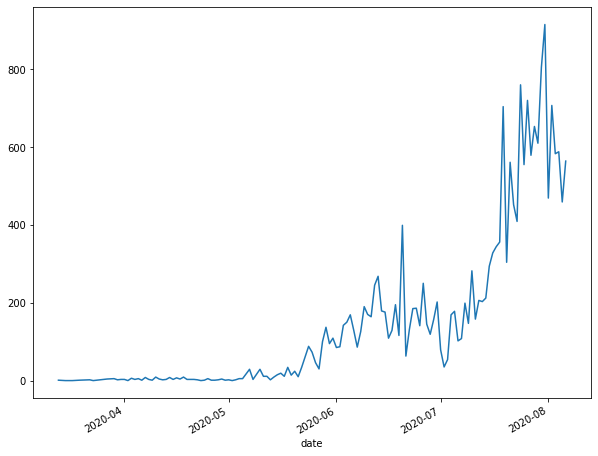

In [ ]:
raw = (pd.read_excel("https://github.com/dev-biniyam/10_academy/blob/master/eth-covid19-data.xlsx?raw=true",sheet_name="DailyCases"))
raw.set_index('date',inplace=True)
new_case = raw.iloc[:,0]
total_cases = raw.iloc[:,1]
plt.figure(figsize=[10,8])
new_case.plot()

In [ ]:
new_case[new_case.isnull()] # check if missing values exit

Series([], Name: confirmed, dtype: int64)

## Split the data
split the data into one part used for inference (training set), and an other used for to validate a forecast (validation set):
- Training set includes all dates from the time the community transmission reaches 100 to July 25 2020.
- Validation set includes dates from 25 July 2020 to one final date in the covid19 cases data

In [ ]:
bd = datetime.datetime(2020, 5, 23)  # For the date filter
ed = datetime.datetime(2020, 8, 5)

In [ ]:
# date = total_cases_obs[total_cases_obs  >= 100].reset_index().head(1)['date'][0]
new_case = new_case[new_case.index > bd]
total_cases = total_cases[total_cases.index > '2020-7-25']

In [ ]:
new_cases_obs = new_case[new_case.index < '2020-7-25']
testing_cases = new_case[new_case.index >= '2020-7-25']
new_cases_obs

date
2020-05-24     88
2020-05-25     73
2020-05-26     46
2020-05-27     30
2020-05-28    100
             ... 
2020-07-20    304
2020-07-21    561
2020-07-22    452
2020-07-23    409
2020-07-24    760
Name: confirmed, Length: 62, dtype: int64



## Create the model

First we need to set the priors for the change points and other configs.


In [ ]:
diff_data_sim = 16  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 23

In [ ]:
# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 6, 25)
prior_date_mild_dist_2 = datetime.datetime(2020, 6, 30)
# prior_date_strong_dist_begin = datetime.datetime(2020, 3, 16)
# prior_date_contact_ban_begin = datetime.datetime(2020, 3, 23)

In [ ]:
change_points = [
     dict(
         pr_mean_date_transient=prior_date_mild_dist_begin,
         pr_sigma_date_transient=3,
         pr_median_lambda=0.2,
         pr_sigma_lambda=1,
     ),
    dict(
        pr_mean_date_transient=prior_date_mild_dist_2,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=0.4,
        pr_sigma_lambda=1,
    ),
    # dict(
    #     pr_mean_date_transient=prior_date_contact_ban_begin,
    #     pr_sigma_date_transient=1.5,
    #     pr_median_lambda=1 / 8 / 2,
    #     pr_sigma_lambda=1,
    # ),
]

change_points_2 =[
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
]

change_points_orig = []




Next, we create the model! There are default values for most of the function arguments,
but we will try to explicitly set all kwargs for the sake of this example.


In [ ]:
params_model = dict(
    new_cases_obs=new_cases_obs[:],
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=110e6,
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10



The model is specified in a context. Each function in this context
has access to the model parameters set.


In [ ]:
def create_model(change_points, params_model):
  with cov19.model.Cov19Model(**params_model) as this_model:
      # Create the an array of the time dependent infection rate lambda
      lambda_t_log = cov19.model.lambda_t_with_sigmoids(
          pr_median_lambda_0=0.4,
          pr_sigma_lambda_0=0.5,
          change_points_list=change_points,  # The change point priors we constructed earlier
          name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
      )

      # set prior distribution for the recovery rate
      mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

      # This builds a decorrelated prior for I_begin for faster inference.
      # It is not necessary to use it, one can simply remove it and use the default argument
      # for pr_I_begin in cov19.SIR
      prior_I = cov19.model.uncorrelated_prior_I(
          lambda_t_log=lambda_t_log,
          mu=mu,
          pr_median_delay=pr_delay,
          name_I_begin="I_begin",
          name_I_begin_ratio_log="I_begin_ratio_log",
          pr_sigma_I_begin=2,
          n_data_points_used=5,
      )

      # Use lambda_t_log and mu to run the SIR model
      new_cases = cov19.model.SIR(
          lambda_t_log=lambda_t_log,
          mu=mu,
          name_new_I_t="new_I_t",
          name_I_t="I_t",
          name_I_begin="I_begin",
          pr_I_begin=prior_I,
      )

      # Delay the cases by a lognormal reporting delay
      new_cases = cov19.model.delay_cases(
          cases=new_cases,
          name_cases="delayed_cases",
          name_delay="delay",
          name_width="delay-width",
          pr_mean_of_median=pr_delay,
          pr_sigma_of_median=0.2,
          pr_median_of_width=0.3,
      )

      # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
      # Also adds the "new_cases" variable to the trace that has all model features.
      new_cases = cov19.model.week_modulation(
          cases=new_cases,
          name_cases="new_cases",
          name_weekend_factor="weekend_factor",
          name_offset_modulation="offset_modulation",
          week_modulation_type="abs_sine",
          pr_mean_weekend_factor=0.3,
          pr_sigma_weekend_factor=0.5,
          weekend_days=(6, 7),
      )

      # Define the likelihood, uses the new_cases_obs set as model parameter
      cov19.model.student_t_likelihood(new_cases)
  return this_model

In [ ]:
mod_a = create_model(change_points, params_model)
mod_b = create_model(change_points_orig, params_model)
mod_c = create_model(change_points_2, params_model)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying case


## MCMC sampling

After the model is built, it is sampled using an MCMC sampler.
The number of parallel runs can be set with the argument `cores=`.
In particular, due to a bug in Theano, Windows users should set `cores=1`.
The sampling can take a long time.


In [16]:
tr_a = pm.sample(model=mod_a,cores= 1, tune=50, draws=100, init="advi+adapt_diag")
tr_b = pm.sample(model=mod_b,cores= 1, tune=50, draws=100, init="advi+adapt_diag")
tr_c = pm.sample(model=mod_c,cores= 1, tune=50, draws=100, init="advi+adapt_diag")
#trace = pm.sample(model=this_model, tune=100, draws=200, init="advi+adapt_diag")

Only 100 samples in chain.
WARNING  [pymc3] Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING  [theano.tensor.blas] We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Average Loss = 444.91:  11%|█▏        | 22997/200000 [02:37<20:10, 146.19it/s]
Convergence achieved at 23000
INFO     [pymc3.variational.inference] Convergence achieved at 23000
Interrupted at 22,999 [11%]: Average Loss = 541.28
INFO     [pymc3.variational.inference] Interrupted at 22,999 [11%]: Average Loss = 541.28
Sequential sampling (2 chains in 1 job)
INFO     [pymc3] Sequential 


## Plotting
Plotting tools are rudimentary right now. But one can always write custom plotting function
by accessing the samples stored in the trace.

### Distributions


Possible varnames are :
['lambda_0_log_', 'lambda_1_log_', 'lambda_2_log_', 'transient_day_1', 'transient_day_2', 'transient_len_1_log_', 'transient_len_2_log_', 'mu', 'I_begin_ratio_log', 'delay_log', 'weekend_factor_log', 'offset_modulation_rad_circular__', 'sigma_obs']


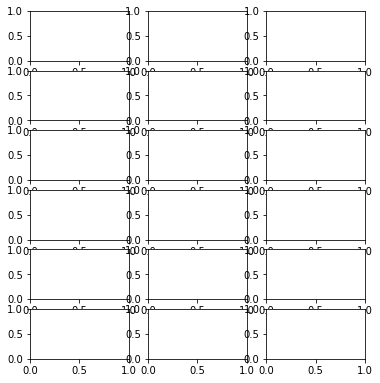

In [17]:
 fig, axes = plt.subplots(6, 3, figsize=(6, 6.4))
varnames = mod_a.untransformed_freeRVs
varnames_c = mod_c.untransformed_freeRVs
print("Possible varnames are :")
print(varnames)

In [18]:
for i, key in enumerate(
    # left column
    ["weekend_factor", "mu", "lambda_0", "lambda_1"]#, "lambda_2", "lambda_3"]
):
    cov19.plot._distribution(mod_a, tr_a, key, ax=axes[i, 0])

In [19]:
for i, key in enumerate(
    # mid column
    [
        "offset_modulation",
        "sigma_obs",
        "I_begin",
        "transient_day_1",
        # "transient_day_2",
        # "transient_day_3",
    ]
):
    cov19.plot._distribution(mod_a, tr_a, key, ax=axes[i, 1])

In [20]:
for i, key in enumerate(
    # right column
    ["delay", "transient_len_1"]#, "transient_len_2", "transient_len_3",]
):
    cov19.plot._distribution(mod_a, tr_a, key, ax=axes[i + 2, 2])

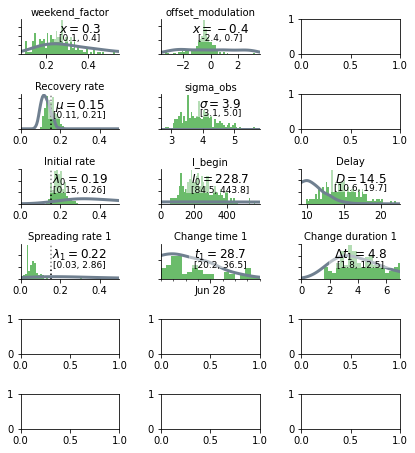

In [21]:
fig.tight_layout()
fig #To print in jupyter notebook


### Timeseries
timeseries overview, for now needs an offset variable to get cumulative cases


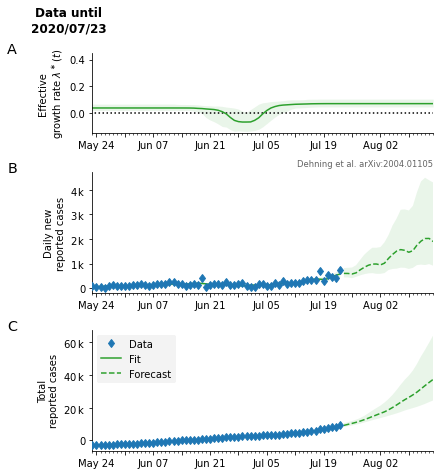

In [22]:
fig, axes = cov19.plot.timeseries_overview(mod_a, tr_a, offset=-3000)

## Plotting


In [23]:
cov19.plot.set_rcparams(cov19.plot.get_rcparams_default())
cov19.plot.rcParams.draw_ci_50 = True

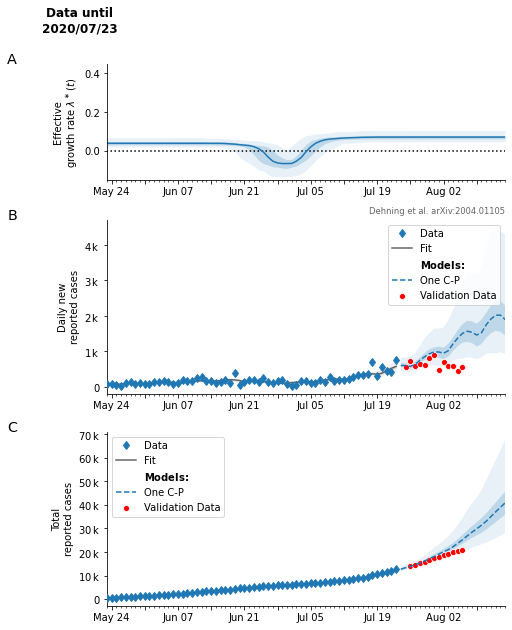

In [41]:
import seaborn as sns

fig, axes = cov19.plot.timeseries_overview(
    mod_a,
    tr_a,
    offset=jhu.get_total(country="Ethiopia", data_begin=bd, data_end=ed)[0],
    forecast_label="One C-P",
    forecast_heading=r"$\bf Models\!:$",
    add_more_later=True,
    color="tab:blue",
)
# fig, axes = cov19.plot.timeseries_overview(
#     mod_b,
#     tr_b,
#     axes=axes,
#     offset=jhu.get_total(country="Ethiopia", data_begin=bd, data_end=ed)[0],
#     forecast_label="No C-P",
#     color="tab:green",
# )

# fig, axes = cov19.plot.timeseries_overview(
#     mod_c,
#     tr_c,
#     axes=axes,
#     offset=jhu.get_total(country="Ethiopia", data_begin=bd, data_end=ed)[0],
#     forecast_label="Two C-P",
#     color="tab:orange",
# )

fig.set_size_inches(11,8)
sns.scatterplot(x=testing_cases.index.tolist(), y=testing_cases.tolist(),color='red', ax=axes[1],label='Validation Data')
sns.scatterplot(x=total_cases.index.tolist(), y=total_cases.tolist(),color='red', ax=axes[2],label='Validation Data')



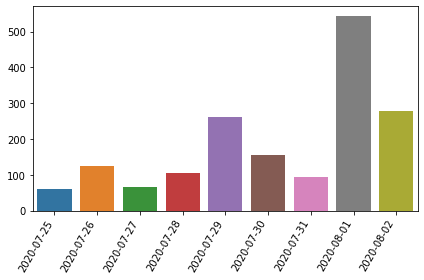

In [39]:
import time
from sklearn.metrics import mean_squared_error
from math import sqrt

# This is to show the errors for each day
y, x = cov19.plot._get_array_from_trace_via_date(
                mod_a, tr_a, "new_cases", datetime.datetime(2020,7,25), datetime.datetime(2020,8,2)
            )
predicted=y.mean(axis=0)
expected = testing_cases[testing_cases.index<'2020-08-03'].tolist()
forecast_errors = [abs(expected[i]-predicted[i]) for i in range(len(predicted))]
testing_cases_list = [ ]

for i in testing_cases[testing_cases.index<'2020-08-03'].index:
  testing_cases_list.append(i.date())

ax = sns.barplot(x=testing_cases_list, y=np.array(forecast_errors))
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha="right")
plt.tight_layout()
